# Jensen-Shannon-Divergence between Amino Acid Distributions

In [1]:
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_with_outliers = pd.concat(dfs)

In [3]:
# Filter to sequences that do not have distr
df = df_with_outliers[df_with_outliers['aa_distr_js'].notnull()]

In [4]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,...,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP
count,514622.000000,514622.00000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514619.000000,514622.000000,514622.000000,...,514622.000000,513491.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000
mean,419.078461,0.57099,30.832029,33.822928,75.292812,79.043856,0.356777,126.151206,0.515753,0.000657,...,0.019857,-0.311983,0.755625,0.976791,0.160911,0.139624,0.112231,0.503103,0.245042,7.336256
std,343.523531,1.10897,1.480910,11.472136,15.024612,18.830840,0.292574,147.682902,4.485592,0.048485,...,0.394819,0.317159,5.020129,3.640865,0.064054,0.039520,0.038881,0.073258,0.056422,1.882249
min,16.000000,0.00000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.987435,0.000000,0.000000,0.030443,0.000000,0.000000,0.000000,0.000000,4.050000
25%,184.000000,0.00000,30.900000,25.650000,64.816400,64.350000,0.112000,37.994850,0.000000,0.000000,...,0.000000,-0.564031,0.000000,0.000000,0.114615,0.116600,0.089500,0.458700,0.211100,5.693900
50%,330.000000,0.00000,31.300000,31.230000,77.941850,87.310000,0.274100,80.004100,0.000000,0.000000,...,0.000000,-0.345583,0.000000,0.000000,0.147983,0.137300,0.112800,0.501500,0.241200,6.948100
75%,534.000000,1.00000,31.400000,38.710000,87.666875,94.025000,0.556400,156.732200,0.000000,0.000000,...,0.000000,-0.103957,0.000000,1.000000,0.193001,0.158900,0.133700,0.546000,0.274000,9.007700
max,2699.000000,46.00000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900,342.000000,11.000000,...,83.000000,0.918797,386.000000,673.000000,0.713420,0.952400,0.888900,1.000000,0.941200,12.000000


In [5]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['aa_distr_js'])
print(f'Spearman rank correlation (Jensen-Shannon): {"{0:.4f}".format(rho)}')

Spearman rank correlation (Jensen-Shannon): 0.3264


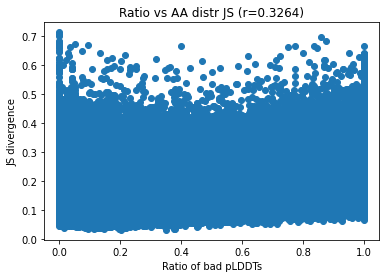

In [8]:
%matplotlib inline
fig, ax = plt.subplots()

ax.scatter(df['ratio_bad_plddt'], df['aa_distr_js'])
ax.set_title('Ratio vs AA distr JS (r=0.3264)')
ax.set_ylabel('JS divergence')
ax.set_xlabel('Ratio of bad pLDDTs')

plt.show()

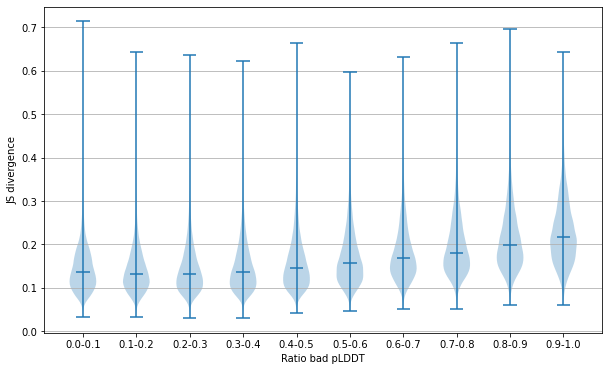

In [10]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, figsize=(10, 6))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    ax.violinplot(dataset = [bucket[prop].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

violin_plot(ax1, 'aa_distr_js', 'JS divergence')